# ML-Based Fetal Abnormality Detection Using Cardiotocography Data


In this project, I will attempt to replicate the diagnoses of a panel of three obstreticians based on data extracted from a cardiotocogram. I will begin by conducting an exploratory analysis of the data, followed by a testing phase of various machine learning algorithms, and finally an evaluation of model performance. This process will be iterative and will involve class balancing, feature selection, and comparisons of various metrics.

- Data source: https://archive.ics.uci.edu/ml/datasets/cardiotocography


- Author: Siddharth Chaphekar


- Published: November 2019

In [ ]:
### Importing EDA and visualization modules
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

### Importing ML modules
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Importing metrics modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz

### Importing dataset
ctg_df = pd.read_csv("CTG.csv")


### Exploratory Data Analysis

To better understand how the predictor variables help classify a fetus as either healthy or pathological, we have to understand the metrics in deeper detail. The class labels are 1 (healthy), 2 (suspect), and 3 (pathologic). The metrics are described as follows:

- LB, baseline heart rate in beats per minute
- AC, # of accelerations per second
- FM, # of fetal movements per second
- UC, # of uterine contractions per second
- ASTV, % of time with abnormal short-term variability
- mSTV, mean value of short term variability
- ALTV, % of time with abnormal long-term variability
- mLTV, mean value of long term variability
- DL/DS/DP/DR, # of light/severe/prolonged/repetitive decelerations per second
- Width/Min/Max/NMax/NZeros, histogram attributes
- Mode/Mean/Median/Variance/Tendency, histogram statistics
- A/B/C/D, calm/REM sleep, calm/active vigilance



In [2]:
### Dataset and class sizes
print("Total samples:      ", len(ctg_df))

normal = ctg_df[ctg_df.NSP == 1] 
print("Healthy samples:    ", len(normal))

suspect = ctg_df[ctg_df.NSP == 2]
print("Suspect samples:    ", len(suspect))

pathologic = ctg_df[ctg_df.NSP == 3]
print("Pathologic samples: ", len(pathologic))


Total samples:       2126
Healthy samples:     1655
Suspect samples:     295
Pathologic samples:  176


In [3]:
### Grouping suspect and pathologic classes together to create binary classification problem
ctg_df.loc[ctg_df['NSP'] == 1, 'NSP'] = 0
ctg_df.loc[ctg_df['NSP'] == 2, 'NSP'] = 1
ctg_df.loc[ctg_df['NSP'] == 3, 'NSP'] = 1

normal = ctg_df[ctg_df.NSP == 0]
suspect = ctg_df[ctg_df.NSP == 1]
print("Suspect/pathologic samples:    ", len(suspect))


Suspect/pathologic samples:     471


In [4]:
### Summary statistics of normal class attributes
normal.describe()


,F,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,...,1655.000000,1655.000000,1655.000000,1655.000000,1655.00000,1655.0,1655.0,1655.0,1655.000000,1655.0
mean,952.833837,1781.982477,131.981873,131.981873,3.424169,6.370997,3.984290,42.465861,1.430634,5.044713,...,0.032024,0.048943,0.001813,0.199396,0.13716,0.0,0.0,0.0,3.387915,0.0
std,915.016651,942.991678,9.454513,9.454513,3.729700,33.825502,2.692368,15.497354,0.818955,11.526078,...,0.176117,0.215813,0.042550,0.399667,0.34412,0.0,0.0,0.0,2.274000,0.0
min,0.000000,287.000000,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.000000,0.0
25%,112.000000,1056.500000,125.000000,125.000000,0.000000,0.000000,2.000000,29.000000,0.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,2.000000,0.0
50%,651.000000,1487.000000,132.000000,132.000000,2.000000,0.000000,4.000000,41.000000,1.300000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,2.000000,0.0
75%,1644.000000,2543.500000,138.000000,138.000000,5.000000,2.000000,6.000000,56.000000,1.750000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,6.000000,0.0
max,3296.000000,3599.000000,160.000000,160.000000,26.000000,564.000000,17.000000,83.000000,7.000000,73.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,0.0,0.0,7.000000,0.0


In [5]:
### Summary statistics of suspect class attributes
suspect.describe()


,F,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,471.000000,471.000000,471.000000,471.000000,471.00000,471.000000,471.000000,471.000000,471.000000,471.000000,...,471.0,471.0,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.0
mean,617.033970,1424.917197,137.949045,137.949045,0.25690,10.299363,2.520170,62.887473,0.988960,26.719745,...,0.0,0.0,0.146497,0.004246,0.053079,0.227176,0.146497,0.418259,8.452229,1.0
std,761.484501,830.289142,9.772604,9.772604,0.74078,46.830541,3.076873,12.881377,1.007316,26.385240,...,0.0,0.0,0.353980,0.065094,0.224429,0.419453,0.353980,0.493798,1.794006,0.0
min,0.000000,301.000000,110.000000,110.000000,0.00000,0.000000,0.000000,18.000000,0.200000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,20.000000,875.000000,131.000000,131.000000,0.00000,0.000000,0.000000,60.000000,0.400000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.0
50%,317.000000,1184.000000,138.000000,138.000000,0.00000,0.000000,1.000000,64.000000,0.500000,20.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.0
75%,928.000000,1779.500000,146.000000,146.000000,0.00000,3.000000,4.000000,70.000000,1.400000,46.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,1.0
max,3073.000000,3599.000000,159.000000,159.000000,6.00000,489.000000,23.000000,87.000000,6.300000,91.000000,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.0


- Correlation matrix shows no indication of any multicollinearity, so no feature elimination in this step.

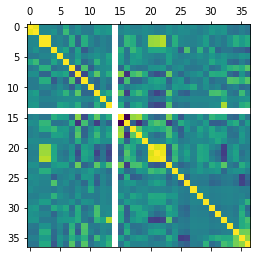

                 F         e       LBE        LB        AC        FM  \
F         1.000000  0.944912 -0.020400 -0.020400 -0.038359 -0.133849   
e         0.944912  1.000000 -0.013979 -0.013979  0.071572 -0.119249   
LBE      -0.020400 -0.013979  1.000000  1.000000 -0.077967 -0.033305   
LB       -0.020400 -0.013979  1.000000  1.000000 -0.077967 -0.033305   
AC       -0.038359  0.071572 -0.077967 -0.077967  1.000000  0.053956   
FM       -0.133849 -0.119249 -0.033305 -0.033305  0.053956  1.000000   
UC        0.225595  0.386856 -0.127722 -0.127722  0.212100 -0.036626   
ASTV     -0.126355 -0.066374  0.305570  0.305570 -0.197985 -0.116461   
MSTV      0.040505  0.044605 -0.279607 -0.279607  0.191378  0.138061   
ALTV     -0.109861 -0.104566  0.285630  0.285630 -0.345162 -0.072214   
MLTV     -0.100027 -0.108141 -0.032091 -0.032091 -0.128901  0.021031   
DL        0.091783  0.163257 -0.155908 -0.155908 -0.011350  0.076283   
DS        0.063977  0.068221 -0.053518 -0.053518 -0.039341 -0.01

In [6]:
### Visualization of correlations
plt.matshow(ctg_df.corr())
plt.show()
print(ctg_df.corr())


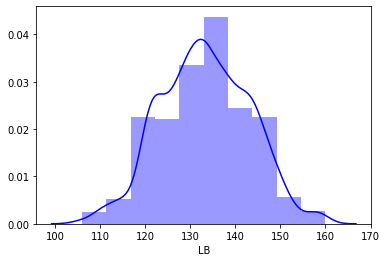

In [7]:
### Distribution of baseline heart rates
sb.distplot(ctg_df['LB'], color = 'b', bins = 10);


- In this step, the differences between the means of some attributes will be visualized:

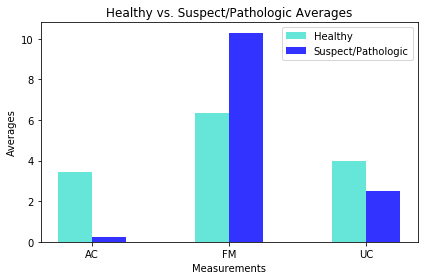

In [8]:
### Basic attribute averages comparisons

# Attributes to be visualized
n_groups = 3
norm_class = (normal.AC.mean(), normal.FM.mean(), normal.UC.mean())
susp_class = (suspect.AC.mean(), suspect.FM.mean(), suspect.UC.mean())

# Bar graph characteristics
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

# Building the bars
rects1 = plt.bar(index, norm_class, bar_width, alpha = opacity, color = 'turquoise', label = 'Healthy')
rects2 = plt.bar(index + bar_width, susp_class, bar_width, alpha = opacity, color = 'blue', label = 'Suspect/Pathologic')

# Show plot
plt.xlabel('Measurements')
plt.ylabel('Averages')
plt.title('Healthy vs. Suspect/Pathologic Averages')
plt.xticks(index + (0.5*bar_width), ('AC', 'FM', 'UC'))
plt.legend()
plt.tight_layout()
plt.show()

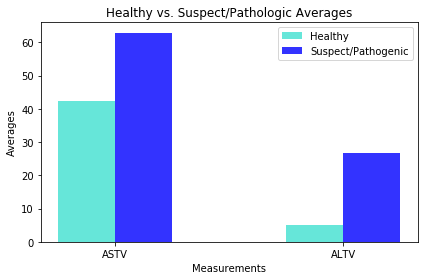

In [9]:
### Basic attribute averages comparisons

# Attributes to be visualized
n_groups = 2
norm_class = (normal.ASTV.mean(), normal.ALTV.mean())
susp_class = (suspect.ASTV.mean(), suspect.ALTV.mean())

# Bar graph characteristics
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

# Building the bars
rects1 = plt.bar(index, norm_class, bar_width, alpha = opacity, color = 'turquoise', label = 'Healthy')
rects2 = plt.bar(index + bar_width, susp_class, bar_width, alpha = opacity, color = 'blue', label = 'Suspect/Pathogenic')

# Show plot
plt.xlabel('Measurements')
plt.ylabel('Averages')
plt.title('Healthy vs. Suspect/Pathologic Averages')
plt.xticks(index + (0.5*bar_width), ('ASTV', 'ALTV'))
plt.legend()
plt.tight_layout()
plt.show()

- Dropping F, e, and LBE. F and e are start and end instants, and LBE is redundant as LB is the same measurement.

In [10]:
# Collection of features
feature_cols = ['LB','AC','FM','UC',                                 # fetal activity/uterine contractions
                'ASTV','MSTV','ALTV','MLTV',                         # variability attributes 
                'DL','DS','DP','DR',                                 # deceleration attributes
                'Width','Min','Max','Nmax','Nzeros',                 # histogram attributes
                'Mode','Mean','Median','Variance','Tendency',        # distribution measurements
                'A','B','C','D',                                     # sleep and vigilance characteristics
                'E','AD','DE','LD','FS','SUSP']                      # pattern attributes

# Feature set
X = ctg_df[feature_cols] 

# Label set
y = ctg_df.NSP


In [11]:
### ML algorithm implementation with class imbalance intact

# Split data, 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 

#clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
#clf = KNeighborsClassifier(n_neighbors = 5)
#clf = SVC(kernel = 'linear', C = 1.0)
#clf = GaussianNB(priors=None, var_smoothing=0.1)
clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 0)

# Fit the chosen classifier
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Performance metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))


Accuracy: 0.9811912225705329
Confusion Matrix:
[[490   3]
 [  9 136]]

Recall:  0.9379310344827586
Precision:  0.9784172661870504
F1:  0.9577464788732394


In [12]:
### Dealing with class imbalance

# Importing imbalance/oversampling module
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))

# SMOTE implementation
sm = SMOTE(random_state = 0)
sm_features, sm_labels = sm.fit_sample(X_train, y_train)
print()

print("After OverSampling, counts of label '0': {}".format(sum(sm_labels == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(sm_labels == 1)))


Using TensorFlow backend.


Before OverSampling, counts of label '0': 1162
Before OverSampling, counts of label '1': 326

After OverSampling, counts of label '0': 1162
After OverSampling, counts of label '1': 1162


In [13]:
### Make classifications after applying SMOTE

clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 0)
#clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
#clf = KNeighborsClassifier(n_neighbors = 5)
#clf = GaussianNB(priors=None, var_smoothing=0.1)
#clf = SVC(kernel = 'linear', C = 1.0)

clf.fit(sm_features, sm_labels)

# Perform predictions on test set
actual = y_test
predictions = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(actual, predictions))
print(confusion_matrix(actual,predictions))
print("Recall: ", recall_score(actual, predictions))
print("Precision: ", precision_score(actual, predictions))
print("F1: ", f1_score(actual, predictions))


false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)


Accuracy: 0.9827586206896551
[[489   4]
 [  7 138]]
Recall:  0.9517241379310345
Precision:  0.971830985915493
F1:  0.9616724738675958
0.9718052738336714


Text(0.5, 0, 'False Positive Rate')

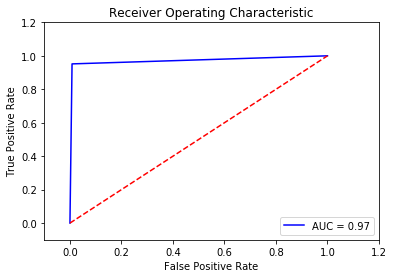

In [14]:
### ROC Curve

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')